<a href="https://colab.research.google.com/github/nurseiit/ml-kachow/blob/master/chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I solved exercise #1.

## What I learned

- Binary Classifier

- Evaluate a model's performance

- Find out `accuracy` is not always a good measure

- Using `Confusion Matrix` in evaluation

    - Further, learn about `precision`, `recall`, and `f_1` scores

- Multiclass, Multilabel, & Multioutput Classifications

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

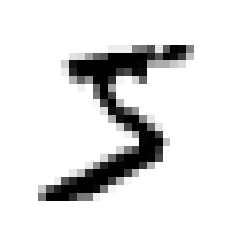

In [5]:
# let's see one of our digits
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# check it's label
print(y[0])
print(type(y[0]))

5
<class 'str'>


In [7]:
import numpy as np

# let's cast strings to ints in labels
y = y.astype(np.uint8)

## Create `test` & `train` sets

In [8]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

## Start by a Binary Classifier

In [9]:
# create target vectors for classifying 5-s
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# let's try Stochastic Gradient Descent or SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # `random_state` for our results to be the same across runs
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([X[0], X[1]])
print(y[0], y[1])

5 0


### Looks a'ight, let's evaluate

Try Cross-Validation first:

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

`> 95% accuracy!` is it not great?

Nope, let's see a comparison:

In [13]:
from sklearn.base import BaseEstimator

class DumbClassifier(BaseEstimator):
  def fit(self, X, y=None):
    # does nothing
    return self
  def predict(self, X):
    # returns all False
    return np.zeros((len(X), 1), dtype=bool)

Pretty dumb, huh?

Let's see how it scores in Cross-Validation:

In [14]:
dumb_clf = DumbClassifier()

cross_val_score(dumb_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

See? It's `> 90% accuracy` with this classifier.

Only `%10` of the dataset consists of `5-s`, so if you always guess `False`, you'll definitely get over 90%!

**This shows that _accuracy_ is not the best performance measure for Classifiers.**

#### Let's use a `Confusion Matrix` instead

In [15]:
from sklearn.model_selection import cross_val_predict

# let's get a predictions set first
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [16]:
from sklearn.metrics import confusion_matrix
# get confusion matrix compared to original labels
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


#### Okay, what do these numbers mean?

When it claims an image as `5`, it is correct `83.7%` of the time. Also, it only detects `65.1%` of real `5-s`.

In [18]:
# now let's combine these 2 via their harmonic mean
# or, we can directly compute it as below
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


### Now let's try out Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) # for our results stay same across runs

In [20]:
# let's try evaluate that
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1)

print(f1_score(y_train_5, y_train_forest_pred))

0.9242275142688446


Pretty good, huh?

## Multiclass Classification

In [21]:
forest_multi_clf = RandomForestClassifier()
forest_multi_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
forest_multi_clf.predict([X[0]])

array([5], dtype=uint8)

In [23]:
cross_val_score(forest_multi_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9662 , 0.96305, 0.96625])

Over `96%` on all folds!

## Mulitlabel Classification

In [24]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
knn_clf.predict([X[0]])

array([[False,  True]])

## Multioutput Classification

In [27]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

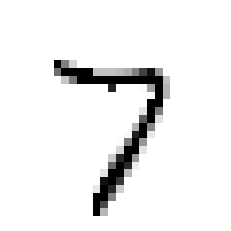

In [30]:
some_index = 0

def plot_digit(digit):
  digit_image = digit.reshape(28, 28)

  plt.imshow(digit_image, cmap="binary")
  plt.axis("off")
  plt.show()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercise 1 Solution